In [1480]:
#import appropriate packages
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.integrate import quad
from scipy.interpolate import interp1d
from scipy.integrate import cumtrapz
from scipy.optimize import minimize
from scipy.interpolate import RegularGridInterpolator
import pandas as pd

In [1481]:
m0 = 1.11542e66 #solar mass in eV
X = 0.7
Y = 0.28
Z = 0.02
mu = 4/(3+5*X)

In [1482]:
mu

0.6153846153846154

In [1483]:
mn = 938.272e6
g_in_ev = 5.60959e32 
cm_in_ev = 50677.3
K_in_ev = 8.61733e-5
erggs_to_dimensionless = 0.5194
cm2g_to_dimensionless = 0.02297
gcm3_to_dimensionless = 0.1693
a = np.pi**2/15 #radiation constant
sigma = np.pi**2/60
r0 = 3.52562e15
P0 = 5.4023e13
rho0 = 2.54525e19
T0 = mu*mn*2.1225e-6

In [1484]:
kappa_data_raw = pd.read_csv("data.csv")
kappa_data_raw = kappa_data_raw.interpolate()
kappa_data_raw2 = kappa_data_raw.to_numpy()

In [1485]:
kappa_data = kappa_data_raw2[:,1:]

In [1486]:
kappa_data.shape

(70, 19)

In [1487]:
kappa_logT = np.array([3.75, 3.8 , 3.85, 3.9 , 3.95, 4.  , 4.05, 4.1 , 4.15, 4.2 , 4.25,
       4.3 , 4.35, 4.4 , 4.45, 4.5 , 4.55, 4.6 , 4.65, 4.7 , 4.75, 4.8 ,
       4.85, 4.9 , 4.95, 5.  , 5.05, 5.1 , 5.15, 5.2 , 5.25, 5.3 , 5.35,
       5.4 , 5.45, 5.5 , 5.55, 5.6 , 5.65, 5.7 , 5.75, 5.8 , 5.85, 5.9 ,
       5.95, 6.  , 6.1 , 6.2 , 6.3 , 6.4 , 6.5 , 6.6 , 6.7 , 6.8 , 6.9 ,
       7.  , 7.1 , 7.2 , 7.3 , 7.4 , 7.5 , 7.6 , 7.7 , 7.8 , 7.9 , 8.  ,
       8.1 , 8.3 , 8.5 , 8.7 ])

In [1488]:
kappa_logR = np.array([-8, -7.5, -7, -6.5, -6, -5.5, -5, -4.5,
       -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5,
       1])

In [1489]:
kappa_interp = RegularGridInterpolator((kappa_logT, kappa_logR), kappa_data, bounds_error=False, fill_value=None)

In [1490]:
logkappa_min = np.min(kappa_data)
logkappa_max = np.max(kappa_data)

In [1491]:
logkappa_min

-2.251

In [1492]:
logkappa_max

5.365

In [1495]:
a0 = 1e-6
a0_p = 1e-13

In [1645]:
def Delta_rad(vec,m):
    l,P,r,T = vec
    # print(kappa(T,P))
    return 3/16/np.pi/a*kappa(T,P)*l*P/(np.abs(m)+a0)/(np.abs(T)+a0)**4

def kappa(T,P):
    T_in_K = T0*(np.abs(T)+a0)/K_in_ev
    logT = np.log10(T_in_K)
    T6 = T_in_K/1e6
    rho = rho_cgs(T,P) 
    R = rho/T6**3
    logR = np.log10(R)
    logkappa = kappa_interp([logT,logR])
    # print(logkappa)
    logkappa = max(logkappa_min,logkappa)
    # print(logkappa)
    logkappa = min(logkappa_max,logkappa)
    # print(logkappa)
    # print(T_in_K)
    # print(logT,logR,logkappa)
    # print(10**(logkappa))
    return 10**(logkappa)*cm2g_to_dimensionless



def Delta_ad():
    return 0.4

def Delta(vec,m):
    return min(Delta_rad(vec,m),Delta_ad())

def rho_cgs(T,P):
    return (np.abs(P)+a0_p)/(np.abs(T)+a0)/gcm3_to_dimensionless

def epsilon_pp(T,P):
    T7 = T0*(np.abs(T)+a0)/K_in_ev/1e7
    T9 = 0.01*T7
    rho= rho_cgs(T,P)
    f11 = np.exp(5.92e-3*(rho/T7**3)**(1/2))
    # f11 = 1 # screening factor np.exp(5.92e-3*(rho_cgs/T7**3)**(1/2))
    g11 = 1  #1+3.82*T9 + 1.51*T9**2+0.144*T9**3-0.0114*T9**4
    psi = 1 ##pp-I branch in the sun
    return 2.57e4*psi*f11*g11*rho*X**2*T9**(-2/3)*np.exp(-3.381/T9**(1/3))*erggs_to_dimensionless


In [1538]:
def structure_ode(vec,m):
    l,P,r,T = vec
    dldm = epsilon_pp(T,P)
    dPdm = -m/4/np.pi/(np.abs(r)+a0)**4
    drdm = 1/4/np.pi*T/(np.abs(P)+a0_p)/(np.abs(r)+a0)**2
    dTdm = -m*T/4/np.pi/(np.abs(P)+a0_p)/(np.abs(r)+a0)**4*Delta(vec, m)
    return [dldm,dPdm,drdm,dTdm]



In [1669]:
def shotting(vec):
    l_s,P_0, r_s, T_0 = vec
    ms = np.linspace(0,0.5,10000)
    load1 = odeint(structure_ode,[1e-7,P_0,1e-7,T_0],ms,full_output=1)
    msinv = np.linspace(1,0.5,10000)
    load2 = odeint(structure_ode,[l_s,8.877e-12,r_s,0.0004],msinv,full_output=1)

    return (load1[0][-1,0]-load2[0][-1,0])**2+(load1[0][-1,1]-load2[0][-1,1])**2/10+(load1[0][-1,2]-load2[0][-1,2])**2+(load1[0][-1,3]-load2[0][-1,3])**2

In [1699]:
shotting([1,15,1.4,1])

0.017536930207836803

In [1700]:
res = minimize(shotting,[ 1,15,  1.4,  1])

In [1701]:
res

      fun: 0.00013721101116108877
 hess_inv: array([[ 0.1419688 ,  1.21243344, -0.38321639,  0.07633474],
       [ 1.21243344, 18.49666912, -3.27287663,  0.91742029],
       [-0.38321639, -3.27287663,  1.0344262 , -0.20606182],
       [ 0.07633474,  0.91742029, -0.20606182,  0.05069541]])
      jac: array([-0.01056363, -0.00035231, -0.00448804,  0.01465796])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 288
      nit: 26
     njev: 56
   status: 2
  success: False
        x: array([ 1.01107679, 15.12306553,  1.39295859,  1.01164574])

In [1723]:
l_s,P_0, r_s, T_0 = res.x
# l_s,P_0, r_s, T_0 =  [1,100,1,1.2]
ms = np.linspace(0,0.5,1000)
load1 = odeint(structure_ode,[1e-4,P_0,1e-4,T_0],ms,full_output=1)
msinv = np.linspace(1,0.5,1000)
load2 = odeint(structure_ode,[l_s,8.877e-12,r_s,0.0004],msinv,full_output=1)
# load3 = odeint(structure_ode,[l_s,8.877e-12,r_s,0.0004],msinv,full_output=1)

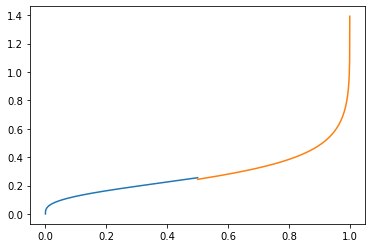

In [1724]:
plt.plot(ms,load1[0][:,2])
plt.plot(msinv,load2[0][:,2])
# plt.plot(msinv,load3[0][:,3])

Text(0, 0.5, '$T/(\\mu m_u GM_{\\odot}/R_{\\odot})}$')

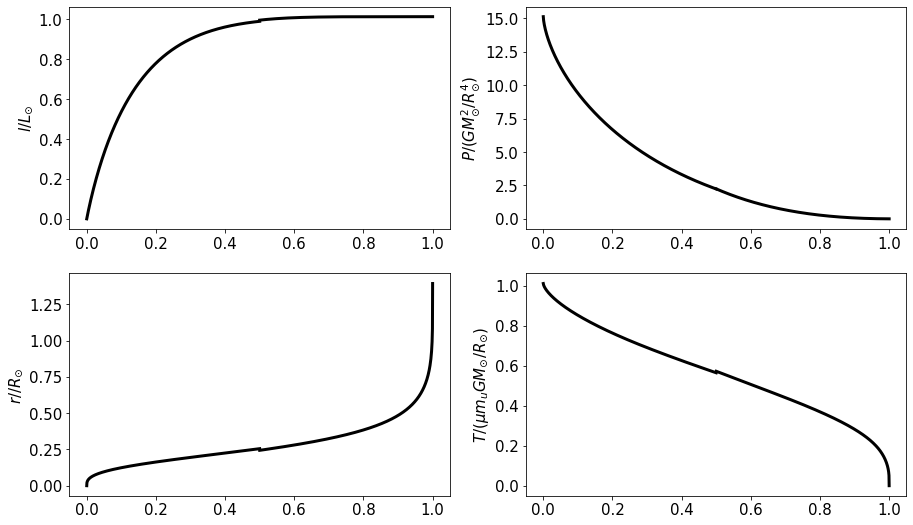

In [1775]:
plt.rcParams["font.size"]  =15
fig, axs = plt.subplots(2,2,figsize = [15,9])
axs[0,0].plot(ms,load1[0][:,0],c = "k", linewidth  =3)
axs[0,0].plot(msinv,load2[0][:,0],c = "k", linewidth  =3)
axs[0,0].set_ylabel(r"$l/L_{\odot}$")
axs[0,1].plot(ms,load1[0][:,1],c = "k", linewidth  =3)
axs[0,1].plot(msinv,load2[0][:,1],c = "k", linewidth  =3)
axs[0,1].set_ylabel(r"$P/(GM_{\odot}^2/R_{\odot}^4)$")
axs[1,0].plot(ms,load1[0][:,2],c = "k", linewidth  =3)
axs[1,0].plot(msinv,load2[0][:,2],c = "k", linewidth  =3)
axs[1,0].set_ylabel(r"$r//R_{\odot}$")
axs[1,1].plot(ms,load1[0][:,3],c = "k", linewidth  =3)
axs[1,1].plot(msinv,load2[0][:,3],c = "k", linewidth  =3)
axs[1,1].set_ylabel(r"$T/(\mu m_u GM_{\odot}/R_{\odot})}$")

In [1730]:
mss = np.concatenate((ms,np.flip(msinv)))

In [1742]:
lss = np.concatenate((load1[0][:,0],np.flip(load2[0][:,0])))
Pss = np.concatenate((load1[0][:,1],np.flip(load2[0][:,1])))
rss = np.concatenate((load1[0][:,2],np.flip(load2[0][:,2])))
Tss = np.concatenate((load1[0][:,3],np.flip(load2[0][:,3])))

In [1782]:
delta_ad = np.zeros_like(mss)
delta_rad = np.zeros_like(mss)
epsilon_pps = np.zeros_like(mss)
# delta_act = np.zeros_like(mss)
for i, m in enumerate(mss):
    l = lss[i]
    P = Pss[i]
    r = rss[i]
    T = Tss[i]
    delta_ad[i] = Delta_ad()
    # delta_act[i] = Delta([l,P,r,T],m)
    delta_rad[i] = Delta_rad([l,P,r,T],m)
    epsilon_pps[i] = epsilon_pp(T,P)

In [1784]:
df = pd.DataFrame(
    {"m": mss,
     "l": lss,
     "P": Pss,
     "r": rss,
     "T": Tss,
     "rho": Pss/Tss,
     "epsilon": epsilon_pps,
     "adiabatic temperature gradient": delta_ad,
     "actual temperature gradient": delta_act,
     "radiative": delta_rad<delta_ad
     }
)

In [1787]:
df.to_csv("result.csv")